In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import networkx as nx
import ast

from nanonets import Simulation
from nanonets.utils import fft, harmonic_strength, total_harmonic_distortion, BLUE_COLOR, get_net_currents, cross_correlation, min_max_scale
from nanonets.utils import create_weighted_undirected_graph, display_net_flow_graph
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.signal import correlate2d, correlate
from scipy.optimize import curve_fit

plt.style.use(["science","bright","grid"])
PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/res_disorder/"
PATH_U = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"
NET_PATHS = "/home/jonasmensing/bagheera/nanonets/scripts/2_funding_period/WP2/data/"

In [3]:
N_PERIODS, SAMPLE_P_PERIOD  = 80, 40
N_NP, N_ELECTRODES          = 9, 8
N_SKIP, N_NETS              = 80, 32
AMPLITUDE                   = 0.02
FREQ_LIST_MHZ               = [0.12,10.,23.]
R_VALS                      = [50,100,200]

In [4]:
topo = {"Nx": N_NP,"Ny": N_NP, "e_pos": [[(N_NP-1)//2, 0],[0, 0],[N_NP-1, 0],
               [0, (N_NP-1)//2],[N_NP-1, (N_NP-1)//2],[0, N_NP-1],
               [N_NP-1, N_NP-1],[(N_NP-1)//2, N_NP-1]],
            "electrode_type": ['constant']*8}
sim_class   = Simulation(topo)
G_obj       = sim_class.get_graph()
pos         = sim_class.get_positions()
pos         = {(key+8 if key >= 0 else (abs(key)-1)) : (val) for key, val in pos.items()}
E_CHARGE    = sim_class.ELE_CHARGE_A_C
CAP_MAT     = sim_class.get_capacitance_matrix()

In [5]:
dts      = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps  = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time     = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data_u   = {freq : pd.read_csv(f"{PATH_U}Nx=9_Ny=9_Ne=8_{freq:.3f}_{0.02:.3f}_constant.csv") for freq in FREQ_LIST_MHZ}
# data_c = {freq : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{freq:.3f}_mean2_50.0_center.csv") for freq in FREQ_LIST_MHZ}
data     = {}
states   = {}
currents = {}
for R in R_VALS:
    data[R]       = {n : {freq : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{freq:.3f}_mean2_{R:.1f}_{n}.csv") for freq in FREQ_LIST_MHZ} for n in range(N_NETS)}
    states[R]     = {n : {freq : pd.read_csv(f"{PATH}mean_state_Nx=9_Ny=9_Ne=8_{freq:.3f}_mean2_{R:.1f}_{n}.csv") for freq in FREQ_LIST_MHZ} for n in range(N_NETS)}
    currents[R]   = {n : {freq : pd.read_csv(f"{PATH}net_currents_Nx=9_Ny=9_Ne=8_{freq:.3f}_mean2_{R:.1f}_{n}.csv") for freq in FREQ_LIST_MHZ} for n in range(N_NETS)}

In [6]:
t_points    = [0,int(0.25*SAMPLE_P_PERIOD),int(0.5*SAMPLE_P_PERIOD),int(0.75*SAMPLE_P_PERIOD)]
phi_states  = {}
q_states    = {}
times       = {}
inputs      = {}
outputs     = {}
for R in R_VALS:
    phi_tmp = {}
    q_tmp   = {}
    t_tmp   = {}
    x_tmp   = {}
    y_tmp   = {}
    for freq in FREQ_LIST_MHZ:
        phi_vecs = []
        q_vecs   = []
        t_vecs   = []
        x_vecs   = []
        y_vecs   = []
        for n in range(N_NETS):
            t       = time[freq][:-1][:-N_SKIP*SAMPLE_P_PERIOD]*1e6
            x       = data[R][n][freq]['E0'].values[N_SKIP*SAMPLE_P_PERIOD:]*1000
            y       = data[R][n][freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:]*1e-6
            phi_vec = states[R][n][freq].iloc[N_SKIP*SAMPLE_P_PERIOD:,N_ELECTRODES:].values
            q_vec   = (CAP_MAT @ phi_vec.T).T/E_CHARGE
            t_vecs.append(t.copy())
            x_vecs.append(x.copy())
            y_vecs.append(y.copy())
            phi_vecs.append(phi_vec.copy())
            q_vecs.append(q_vec.copy())
        phi_tmp[freq] = phi_vecs
        q_tmp[freq] = q_vecs
        t_tmp[freq] = t_vecs
        x_tmp[freq] = x_vecs
        y_tmp[freq] = y_vecs
    phi_states[R]   = phi_tmp
    q_states[R]     = q_tmp
    times[R]        = t_tmp
    inputs[R]       = x_tmp
    outputs[R]      = y_tmp

### Spatial Correlation

In [7]:
def get_2D_correlation(arr):
    
    def exp_decay(x, length):
        return np.exp(-x / length)

    arr = arr - np.mean(arr)
    a_c = correlate2d(arr, arr, mode='same', boundary='wrap')
    a_c = a_c / np.max(a_c)

    center_y = a_c.shape[0] // 2
    profile  = a_c[center_y, :]
    lags     = np.arange(profile.size) - (profile.size // 2)

    positive_lags    = lags[lags >= 0]
    decaying_profile = profile[lags >= 0]
    params, _   = curve_fit(exp_decay, positive_lags, decaying_profile)
    corr_length = params[0]

    return a_c, corr_length

N_samples   = 20
q_c_max     = {}
q_c_zero    = {}
phi_c_max   = {}
phi_c_zero  = {}

for R in R_VALS:
    q_c_max2     = {}
    q_c_zero2    = {}
    phi_c_max2   = {}
    phi_c_zero2  = {}
    for freq in FREQ_LIST_MHZ:
        q_c_max_tmp = []
        q_c_zero_tmp = []
        phi_c_max_tmp = []
        phi_c_zero_tmp = []
        for n in range(N_NETS):
            vals = [get_2D_correlation(q_states[R][freq][n][i*SAMPLE_P_PERIOD].copy().reshape(9,9)) for i in range(N_samples)]
            q_c_max_tmp.append(vals)

            vals = [get_2D_correlation(q_states[R][freq][n][i*SAMPLE_P_PERIOD + int(0.25*SAMPLE_P_PERIOD)].copy().reshape(9,9)) for i in range(N_samples)]
            q_c_zero_tmp.append(vals)

            vals = [get_2D_correlation(phi_states[R][freq][n][i*SAMPLE_P_PERIOD].copy().reshape(9,9)) for i in range(N_samples)]
            phi_c_max_tmp.append(vals)

            vals = [get_2D_correlation(phi_states[R][freq][n][i*SAMPLE_P_PERIOD + int(0.25*SAMPLE_P_PERIOD)].copy().reshape(9,9)) for i in range(N_samples)]
            phi_c_zero_tmp.append(vals)
        q_c_max2[freq]      = q_c_max_tmp
        q_c_zero2[freq]     = q_c_zero_tmp
        phi_c_max2[freq]    = phi_c_max_tmp
        phi_c_zero2[freq]   = phi_c_zero_tmp
    q_c_max[R]      = q_c_max2
    q_c_zero[R]     = q_c_zero2
    phi_c_max[R]    = phi_c_max2
    phi_c_zero[R]   = phi_c_zero2

phi_c_m_max     = {R : {freq : [np.mean(np.array([q_c_max[R][freq][n][j][0] for j in range(N_samples)]),axis=0) for n in range(N_NETS)] for freq in FREQ_LIST_MHZ} for R in R_VALS}
phi_c_m_zero    = {R : {freq : [np.mean(np.array([q_c_zero[R][freq][n][j][0] for j in range(N_samples)]),axis=0) for n in range(N_NETS)] for freq in FREQ_LIST_MHZ} for R in R_VALS}
phi_c_l_max     = {R : {freq : [np.array([q_c_max[R][freq][n][j][1] for j in range(N_samples)]) for n in range(N_NETS)] for freq in FREQ_LIST_MHZ} for R in R_VALS}
phi_c_l_zero    = {R : {freq : [np.array([q_c_zero[R][freq][n][j][1] for j in range(N_samples)]) for n in range(N_NETS)] for freq in FREQ_LIST_MHZ} for R in R_VALS}

In [8]:
df_phi_c_l = pd.DataFrame()
for R in R_VALS:
    for freq in FREQ_LIST_MHZ:
        for n in range(N_NETS):
            df = pd.DataFrame()
            df['c_l']   = phi_c_l_zero[R][freq][n]
            df['U0']    = '$U_0 = off$'
            df['R']     = R
            df['freq']  = freq
            df['n']     = n
            df_phi_c_l  = pd.concat([df_phi_c_l, df], ignore_index=True)
            df = pd.DataFrame()
            df['c_l']   = phi_c_l_max[R][freq][n]
            df['U0']    = '$U_0 = on$'
            df['R']     = R
            df['freq']  = freq
            df['n']     = n
            df_phi_c_l  = pd.concat([df_phi_c_l, df], ignore_index=True)
df_phi_c_l.to_csv("c_l.csv")

In [10]:
FREQ_LIST_MHZ

[0.12, 10.0, 23.0]

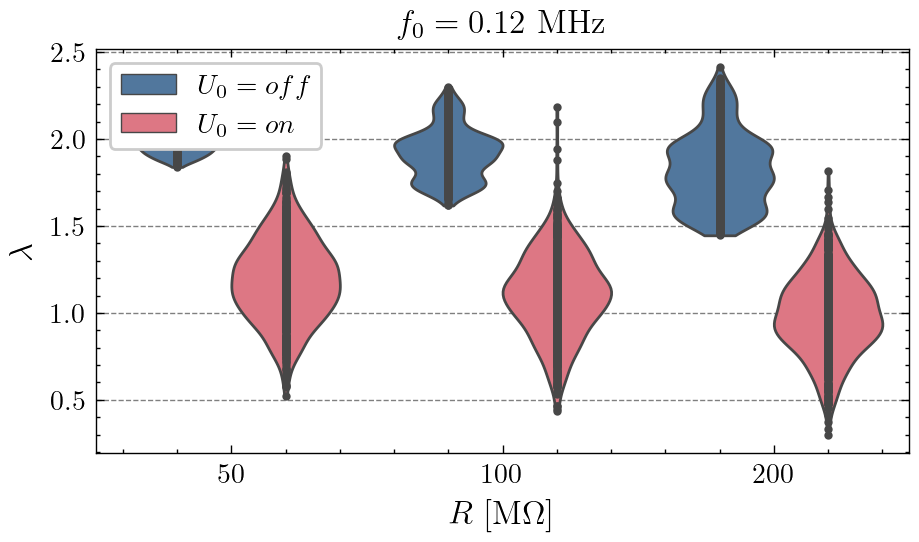

In [12]:
freq = 0.12
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.5)
ax  = fig.add_subplot()
ax  = sns.violinplot(data=df_phi_c_l[df_phi_c_l['freq']==freq], x='R', y='c_l', hue='U0', inner='points', scale='width', cut=0)
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.legend(handles=handles, labels=labels, loc='upper left', title='')
_   = ax.set_xlabel("$R$ [M$\Omega$]", fontsize='large')
_   = ax.set_ylabel("$\lambda$", fontsize='large')
_   = ax.set_title(f'$f_0 = {freq}$ MHz')
fig.savefig(f"plots/svg/internal/corr_length_vs_R_{freq:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/internal/corr_length_vs_R_{freq:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/internal/corr_length_vs_R_{freq:.3f}.png", transparent=False)

### Time Constants

In [13]:
taus = {}
for R in R_VALS:
    taus2 = {}
    for freq in FREQ_LIST_MHZ:
        taus_tmp = []
        for n in range(N_NETS):
            taus_tmp2 = [] 
            x_vals = inputs[R][freq][n].copy()
            for i in range(N_NP*N_NP):
                y_vals      = q_states[R][freq][n][:,i]
                c_vals      = correlate(y_vals, x_vals, mode='same')
                midpoint    = len(c_vals) // 2
                i_val       = np.argmax(np.abs(c_vals)) - midpoint
                t_val       = i_val * dts[freq]
                T           = 1 / (freq * 1e6)
                t_val_phys  = t_val % T
                taus_tmp2.append(t_val_phys / T)

                # if t_val < 0:
                #     t_val = t_val + T
                # taus_tmp2.append(t_val / T)
            taus_tmp.append(taus_tmp2)
        taus2[freq] = taus_tmp
    taus[R] = taus2
# taus_df = pd.DataFrame([taus[i,:] for i in range(len(FREQ_LIST_MHZ))], index=FREQ_LIST_MHZ).T.melt(var_name='freq',value_name='tau')

In [14]:
tau_df = pd.DataFrame()
for R in R_VALS:
    for freq in FREQ_LIST_MHZ:
        for n in range(N_NETS):
            df = pd.DataFrame()
            df['tau']   = taus[R][freq][n]
            df['R']     = R
            df['freq']  = freq
            df['n']     = n
            tau_df      = pd.concat([tau_df, df], ignore_index=True)

In [194]:
FREQ_LIST_MHZ

[0.12, 10.0, 23.0]

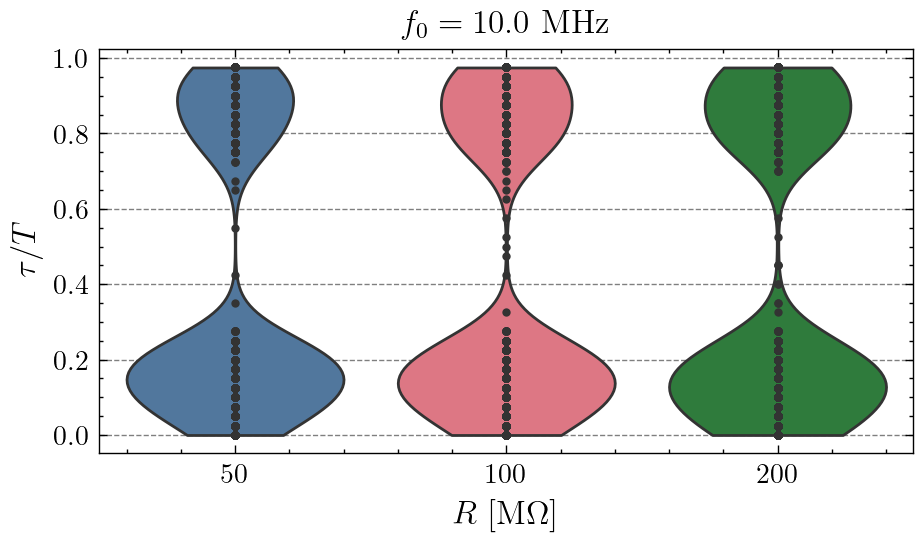

In [16]:
freq = 10.0
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.5)
ax  = fig.add_subplot()
ax  = sns.violinplot(data=tau_df[tau_df['freq']==freq], x='R', y='tau', inner='points', scale='width', cut=0)
_   = ax.set_xlabel("$R$ [M$\Omega$]", fontsize='large')
_   = ax.set_ylabel("$\\tau / T$", fontsize='large')
_   = ax.set_title(f'$f_0 = {freq}$ MHz')
fig.savefig(f"plots/svg/internal/tau_vs_R_{freq:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/internal/tau_vs_R_{freq:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/internal/tau_vs_R_{freq:.3f}.png", transparent=False)

### Percolation

In [17]:
rms_gs      = {}
rms_flow    = {}
for R in R_VALS:
    rms_gs2     = {}
    rms_flow2   = {}
    for freq in FREQ_LIST_MHZ:
        rms_tmp     = []
        rms_tmp2    = []
        for n in range(N_NETS):
            df_net  = get_net_currents(currents[R][n][freq].copy()*1e-6)
            G       = create_weighted_undirected_graph(np.sqrt((df_net**2).sum()))
            rms_tmp.append(G)
            rms_tmp2.append(nx.maximum_flow_value(G, _s=0, _t=7, capacity='weight'))
        rms_gs2[freq]   = rms_tmp
        rms_flow2[freq] = rms_tmp2
    rms_gs[R]   = rms_gs2
    rms_flow[R] = rms_flow2

In [18]:
df_flow = pd.DataFrame()
for R in R_VALS:
    for freq in FREQ_LIST_MHZ:
        df = pd.DataFrame()
        df['flow']  = rms_flow[R][freq]
        df['R']     = R
        df['freq']  = freq
        df_flow     = pd.concat([df_flow, df], ignore_index=True)

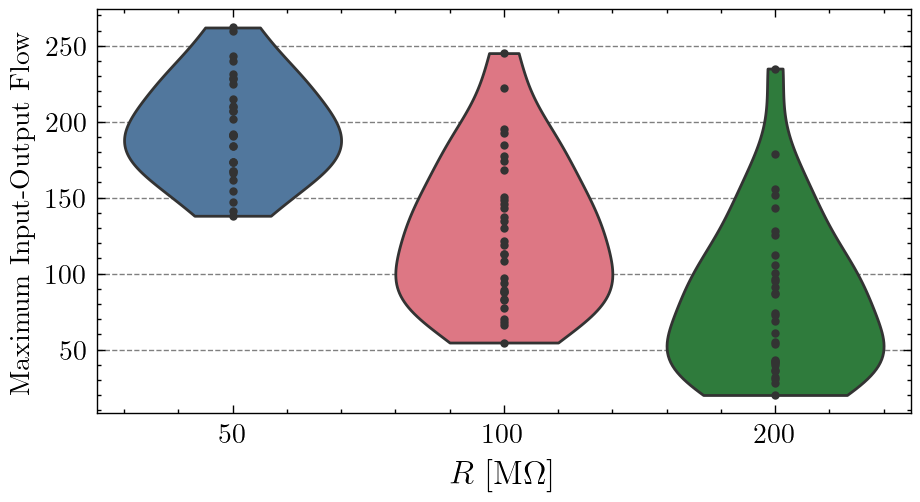

In [21]:
freq = 10.
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.5)
ax  = fig.add_subplot()
ax  = sns.violinplot(data=df_flow[df_flow['freq']==freq], x='R', y='flow', inner='points', scale='width', cut=0)
_   = ax.set_ylabel("Maximum Input-Output Flow")
_   = ax.set_xlabel("$R$ [M$\Omega$]", fontsize='large')
fig.savefig(f"plots/svg/internal/net_flow_vs_R_{freq:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/internal/net_flow_vs_R_{freq:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/internal/net_flow_vs_R_{freq:.3f}.png", transparent=False)

In [40]:
max_idx = np.argmax(np.mean(phi_c_l_max[200][10],axis=1))
min_idx = np.argmin(np.mean(phi_c_l_max[200][10],axis=1))

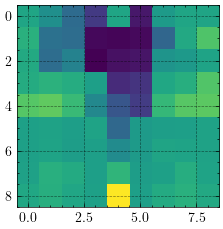

In [54]:
plt.imshow(q_states[200][10.0][min_idx][0].reshape(9,9))

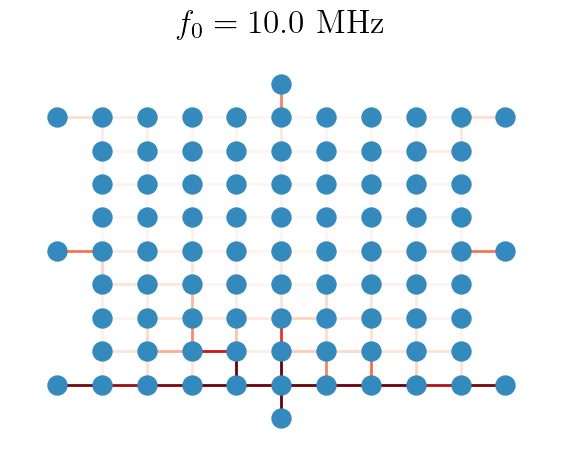

In [45]:
R    = 200
freq = 10.0
fig, ax = plt.subplots(dpi=200)
ax = display_net_flow_graph(rms_gs[R][freq][max_idx], pos=pos, log_sacle=False, font_size=None, ax=ax, vmin=0, vmax=1000)
_  = ax.set_title(f"$f_0 = {freq}$ MHz")
# fig.savefig(f"plots/svg/internal/net_flow_rms_{freq:.3f}.svg", transparent=True)
# fig.savefig(f"plots/pdf/internal/net_flow_rms_{freq:.3f}.pdf", transparent=False)
# fig.savefig(f"plots/png/internal/net_flow_rms_{freq:.3f}.png", transparent=False)

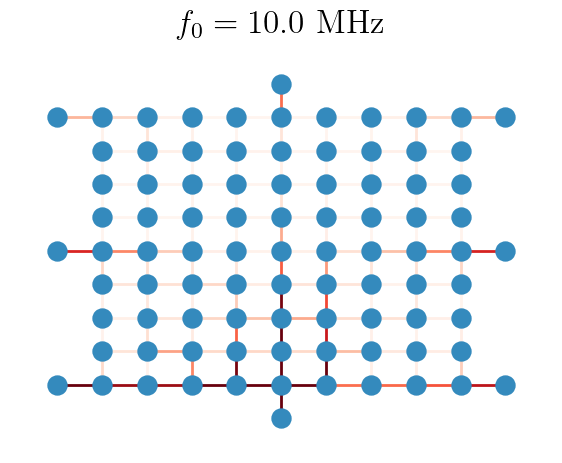

In [44]:
R    = 200
freq = 10.0
fig, ax = plt.subplots(dpi=200)
ax = display_net_flow_graph(rms_gs[R][freq][min_idx], pos=pos, log_sacle=False, font_size=None, ax=ax, vmin=0, vmax=1000)
_  = ax.set_title(f"$f_0 = {freq}$ MHz")
# fig.savefig(f"plots/svg/internal/net_flow_rms_{freq:.3f}.svg", transparent=True)
# fig.savefig(f"plots/pdf/internal/net_flow_rms_{freq:.3f}.pdf", transparent=False)
# fig.savefig(f"plots/png/internal/net_flow_rms_{freq:.3f}.png", transparent=False)